---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

## 1 Read data and basic data integration

List all data files in the working directory

### 1.1 Read training and testing data

In [1]:
from subprocess import check_output
print(check_output(["/bin/sh", "-c", "ls -l *.csv"]).decode("utf8"))

-rw-r--r--@ 1 sheng  staff  11029863  4 Jun 17:12 addresses.csv
-rw-r--r--@ 1 sheng  staff   6158646  4 Jun 17:12 latlons.csv
-rw-r--r--@ 1 sheng  staff  19880261  4 Jun 16:57 test.csv
-rw-r--r--@ 1 sheng  staff  97391029  4 Jun 17:06 train.csv



In [2]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('train.csv', dtype={11:str, 12:str, 31:str}, encoding='mac_roman', parse_dates = ['hearing_date', 'ticket_issued_date'])
train_df = train_df[train_df.compliance.notnull()]

test_df = pd.read_csv('test.csv', parse_dates = ['hearing_date', 'ticket_issued_date'])
test_df.set_index('ticket_id', inplace=True)

### 1.2 Merge and map Address

In [3]:
from collections import Counter
addr_df = pd.read_csv('addresses.csv')
latlons_df = pd.read_csv('latlons.csv')

addr_df = addr_df.merge(latlons_df, left_on='address', right_on='address')

train_df = train_df.merge(addr_df, left_on='ticket_id', right_on='ticket_id')
train_df.drop(['violation_street_number', 'violation_street_name', 'address'], axis=1, inplace=True)

addr_df.drop('ticket_id', axis=1, inplace=True)
addr_df['address'] = addr_df['address'].str.split(',').str.get(0)
addr_df.drop_duplicates('address', inplace=True)

test_df['address'] = test_df['violation_street_number'].astype('int').astype('str') + ' ' + test_df['violation_street_name'].str.lower()
test_df = test_df.merge(addr_df, left_on='address', right_on='address', how='left')
test_df.drop(['violation_street_name', 'violation_street_number', 'address', 'violation_zip_code',
              'grafitti_status', 'non_us_str_code', 'violation_description'], axis=1, inplace=True)

lat_counter = dict(Counter(train_df.lat))
lon_counter = dict(Counter(train_df.lon))

lat_impute = sorted(lat_counter, key=lat_counter.get, reverse=True)[0]
lon_impute = sorted(lon_counter, key=lon_counter.get, reverse=True)[0]

train_df['lat'].fillna(lat_impute, inplace=True)
train_df['lon'].fillna(lon_impute, inplace=True)

test_df['lat'].fillna(lat_impute, inplace=True)
test_df['lon'].fillna(lon_impute, inplace=True)

# Combine mailing address
train_df['mailing_address'] = train_df['mailing_address_str_number'].astype(str) + ' ' + \
                              train_df['mailing_address_str_name'].astype(str) + ' ' + \
                              train_df['city'].astype(str) + ' ' + \
                              train_df['state'].astype(str) + ' ' + \
                              train_df['country'].astype(str)
test_df['mailing_address'] = test_df['mailing_address_str_number'].astype(str) + ' ' + \
                             test_df['mailing_address_str_name'].astype(str) + ' ' + \
                             test_df['city'].astype(str) + ' ' + \
                             test_df['state'].astype(str) + ' ' + \
                             test_df['country'].astype(str)

train_df.drop(['mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'country'], 
              axis=1, inplace=True)
test_df.drop(['mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'country'], 
             axis=1, inplace=True)

### 1.4 Generate new date feature

In [4]:
train_df['hearing_date'] = pd.to_numeric(train_df['hearing_date'])
train_df['ticket_issued_date'] = pd.to_numeric(train_df['ticket_issued_date'])
test_df['hearing_date'] = pd.to_numeric(test_df['hearing_date'])
test_df['ticket_issued_date'] = pd.to_numeric(test_df['ticket_issued_date'])

train_df['time_to_hearing'] = train_df['hearing_date'] - train_df['ticket_issued_date']
test_df['time_to_hearing'] = test_df['hearing_date'] - test_df['ticket_issued_date']

train_df.drop(['hearing_date', 'ticket_issued_date'], axis=1, inplace=True)
test_df.drop(['hearing_date', 'ticket_issued_date'], axis=1, inplace=True)

# from datetime import timedelta
# train_df['time_to_hearing'][train_df['time_to_hearing'] < timedelta(0)]

### 1.5 Remove features not in test data

In [5]:
train_df.drop(
    ['payment_amount', 'payment_date', 'payment_status', 'balance_due', 'collection_status', 'compliance_detail'], 
    axis=1, inplace=True)

## 2 Exploratory Data Analysis

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
train_df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_zip_code,zip_code,non_us_str_code,violation_code,violation_description,disposition,...,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status,compliance,lat,lon,mailing_address,time_to_hearing
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",NaN,60606,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,...,25.0,0.0,0.0,305.0,NaN,0.0,42.390729,-83.124268,3.0 S. WICKER CHICAGO IL USA,31963800000000000
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",NaN,48208,NaN,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,...,75.0,0.0,0.0,855.0,NaN,1.0,42.326937,-83.135118,2959.0 Martin Luther King Detroit MI USA,32662800000000000
2,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",NaN,908041512,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,...,25.0,0.0,0.0,305.0,NaN,0.0,42.145257,-83.208233,2755.0 E. 17TH LOG BEACH CA USA,27988800000000000
3,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",NaN,48038,NaN,61-63.0500,Failed To Secure Permit For Lawful Use Of Land,Responsible by Default,...,75.0,0.0,0.0,855.0,NaN,0.0,42.433466,-83.023493,476.0 Garfield Clinton MI USA,21861900000000000
4,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",NaN,48211,NaN,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,...,10.0,0.0,0.0,140.0,NaN,0.0,42.388641,-83.037858,8228.0 Mt. Elliott Detroit MI USA,21695400000000000


In [8]:
train_df.describe()

,ticket_id,violation_zip_code,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,lat,lon,time_to_hearing
count,159880.000000,0.0,159880.000000,159880.0,159880.0,159880.000000,159880.000000,159880.0,159880.000000,159880.000000,159880.000000,159880.000000,1.598800e+05
mean,150453.858794,NaN,357.035295,20.0,10.0,33.651512,0.195959,0.0,420.650218,0.072536,42.389746,-83.111531,1.769197e+16
std,77224.650876,NaN,675.655580,0.0,0.0,67.692916,4.290344,0.0,742.555062,0.259374,0.037120,0.093516,3.017541e+17
min,18645.000000,NaN,0.000000,20.0,10.0,0.000000,0.000000,0.0,0.000000,0.000000,42.145257,-84.403766,-2.904120e+16
25%,83370.750000,NaN,200.000000,20.0,10.0,10.000000,0.000000,0.0,250.000000,0.000000,42.364537,-83.185856,2.678400e+15
50%,149777.500000,NaN,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,42.392575,-83.124524,4.738800e+15
75%,217480.250000,NaN,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,42.419160,-83.033202,8.720100e+15
max,299363.000000,NaN,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,1.000000,44.785389,-82.512936,8.114996e+18


In [9]:
train_df.dtypes

ticket_id                  int64
agency_name               object
inspector_name            object
violator_name             object
violation_zip_code       float64
zip_code                  object
non_us_str_code           object
violation_code            object
violation_description     object
disposition               object
fine_amount              float64
admin_fee                float64
state_fee                float64
late_fee                 float64
discount_amount          float64
clean_up_cost            float64
judgment_amount          float64
grafitti_status           object
compliance               float64
lat                      float64
lon                      float64
mailing_address           object
time_to_hearing            int64
dtype: object

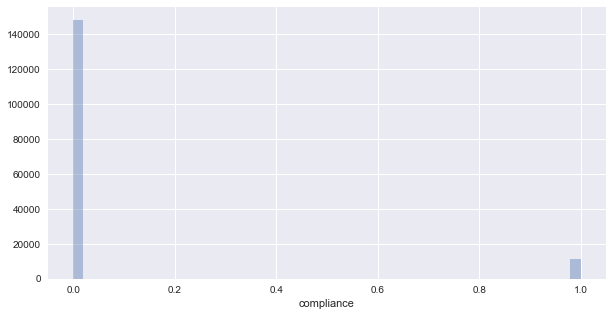

In [10]:
plt.figure(figsize=(10, 5))
sns.distplot(train_df.compliance, kde=False)

### 2.2 Missing Values

In [11]:
train_df.shape

(159880, 23)

In [12]:
for col in train_df.columns.values:
    if len(train_df[train_df[col].isnull()][col]) > 0:
        print("{0}: {1}".format(col, len(train_df[train_df[col].isnull()][col])))

violator_name: 26
violation_zip_code: 159880
zip_code: 1
non_us_str_code: 159877
grafitti_status: 159880


#### Remove features which has very few valid data

In [13]:
# Drop ticket_id and missing value features and redundant features
# As date in train and test are different, so drop the date features
train_df.drop(['violation_zip_code', 'non_us_str_code', 'grafitti_status'], axis=1, inplace=True)

### 2.3 Remove useless and redundant features

In [14]:
# Drop ticket_id because it's useless for modeling.
# As date in train and test are different, so drop the date features
train_df.drop(['ticket_id', 'violation_description'], axis=1, inplace=True)

### 2.4 Plotting remaining numeric features

In [15]:
numeric_features = [column for column, dtype in zip(train_df.columns, train_df.dtypes) if dtype == 'float64' or dtype == 'int64']
numeric_features

['fine_amount',
 'admin_fee',
 'state_fee',
 'late_fee',
 'discount_amount',
 'clean_up_cost',
 'judgment_amount',
 'compliance',
 'lat',
 'lon',
 'time_to_hearing']

In [16]:
for column in numeric_features:
    print(column)
    print(train_df[column].value_counts())
    print("\n\n")

fine_amount
250.0      86798
50.0       20415
100.0      15488
200.0      12710
500.0       6918
1000.0      4965
3500.0      3859
300.0       3768
2500.0      1545
25.0        1378
125.0        793
1500.0       264
750.0        229
0.0          195
10000.0      195
350.0        128
5000.0        85
1200.0        40
400.0         39
2000.0        16
7000.0        13
600.0         10
220.0          4
3000.0         4
1250.0         2
95.0           2
1750.0         2
150.0          2
160.0          2
450.0          1
20.0           1
655.0          1
2695.0         1
677.0          1
170.0          1
8000.0         1
270.0          1
1.0            1
970.0          1
1030.0         1
Name: fine_amount, dtype: int64



admin_fee
20.0    159880
Name: admin_fee, dtype: int64



state_fee
10.0    159880
Name: state_fee, dtype: int64



late_fee
25.0      79621
5.0       17655
0.0       15458
10.0      12516
20.0      11354
50.0       6545
100.0      4803
350.0      3785
30.0       3680
250.

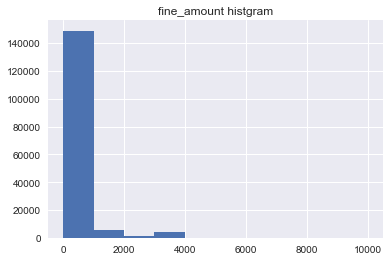

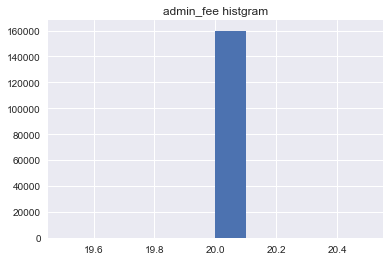

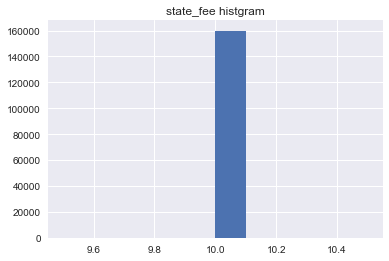

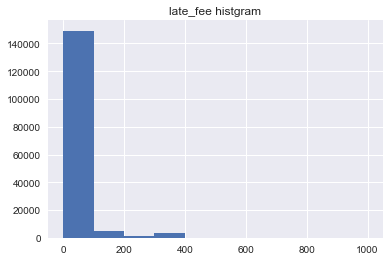

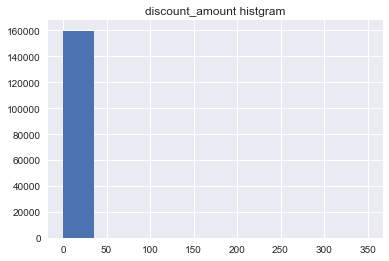

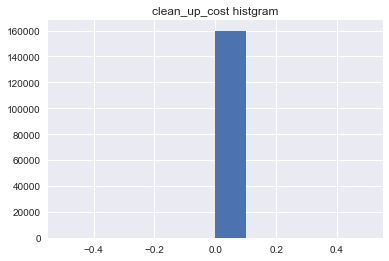

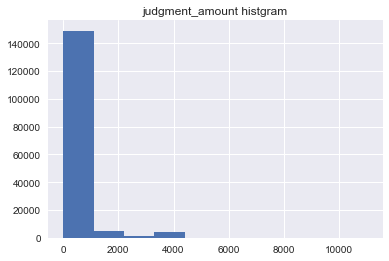

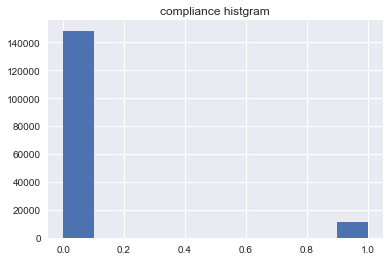

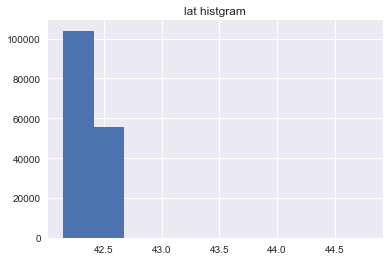

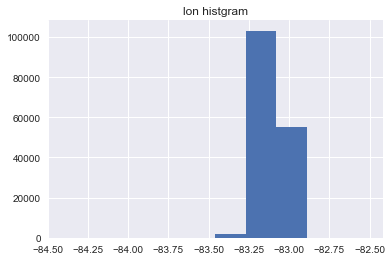

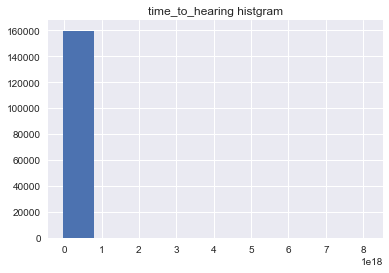

In [17]:
for column in numeric_features:
    plt.figure()
    train_df[column].hist()
    plt.title(column + ' histgram')

In [18]:
train_df.drop(['admin_fee', 'state_fee', 'discount_amount', 'clean_up_cost'], axis=1, inplace=True)

### 2.5 Checking non-numeric features

In [19]:
object_features = [column for column, dtype in zip(train_df.columns, train_df.dtypes) if dtype == 'object']
object_features

['agency_name',
 'inspector_name',
 'violator_name',
 'zip_code',
 'violation_code',
 'disposition',
 'mailing_address']

In [20]:
for column in object_features:
    print(column)
    print(train_df[column].value_counts())
    print("\n\n")

agency_name
Buildings, Safety Engineering & Env Department    95863
Department of Public Works                        52445
Health Department                                  7107
Detroit Police Department                          4464
Neighborhood City Halls                               1
Name: agency_name, dtype: int64



inspector_name
Morris, John            11604
Samaan, Neil J           8720
O'Neal, Claude           8075
Steele, Jonathan         6962
Devaney, John            6837
Hayes, Billy J           6385
Sloane, Bennie J         5624
Sims, Martinzie          5526
Zizi, Josue              5060
Doetsch, James           4337
Danielson, Keith D       3880
Gailes, Orbie J          3451
Jones, Leah              3014
Davis, Darlene           2770
Legge, Gerald            2598
Havard, Jacqueline       2435
Sharpe, Anthony          2401
Johnson, Lois            2062
Harris, Rickey           1947
DeRamer, Andrew          1946
Moore, David             1825
Frazier, Willie          180

## 3 Building models using different classifiers with default parameters

### 3.1 Split X, y from train_df

In [21]:
target = 'compliance'
column_names = list(train_df.columns)
column_names.remove(target)

X = train_df[column_names].copy()
y = train_df[target].copy()

In [22]:
columns_has_null = []
for col in X.columns.values:
    if len(X[X[col].isnull()][col]) > 0:
        print("{0}: {1}".format(col, len(X[X[col].isnull()][col])))
        columns_has_null.append(col)

violator_name: 26
zip_code: 1


In [23]:
X.fillna(value='dummy', inplace=True)

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159880 entries, 0 to 159879
Data columns (total 13 columns):
agency_name        159880 non-null object
inspector_name     159880 non-null object
violator_name      159880 non-null object
zip_code           159880 non-null object
violation_code     159880 non-null object
disposition        159880 non-null object
fine_amount        159880 non-null float64
late_fee           159880 non-null float64
judgment_amount    159880 non-null float64
lat                159880 non-null float64
lon                159880 non-null float64
mailing_address    159880 non-null object
time_to_hearing    159880 non-null int64
dtypes: float64(5), int64(1), object(7)
memory usage: 17.1+ MB


In [25]:
label_columns = ['agency_name', 'inspector_name', 'violator_name', 'zip_code', 'violation_code', 'disposition',
                 'lat', 'lon', 'mailing_address']
numeric_columns = ['fine_amount', 'late_fee', 'judgment_amount', 'time_to_hearing']

In [26]:
X['time_to_hearing'] = X['time_to_hearing'].astype(np.float64)

### 3.2 Encoding string variables

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for column in label_columns:
    values_in_X = set(X[column].astype(str).unique())
    column_with_dummy = X[column].astype(str).append(pd.Series(['dummy']), ignore_index=True)
    column_encoded = le.fit_transform(column_with_dummy)
    X[column] = column_encoded[:-1]

    test_df[column] = test_df[column].astype(str)
    test_df[column] = test_df[column].apply(lambda x: x if x in values_in_X else 'dummy')

    column_encoded_test = le.transform(test_df[column])
    test_df[column] = column_encoded_test

### 3.3 Scaling numeric variables

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for column in numeric_columns:
    X[column] = scaler.fit_transform(X[column].values.reshape(-1,1))
    test_df[column] = scaler.transform(test_df[column].values.reshape(-1,1))

### 3.4 Split training data and testing data for modelling

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

### 3.5 Define basic classifiers

In [30]:
clf_dict = dict()

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf_dict['Gradient Boosting Classifier'] = clf
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf_dict['AdaBoost Classifier'] = clf
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf_dict['Random Forest Classifier'] = clf
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf_dict['KNeighbors Classifier'] = clf

### 3.6 Build models

In [31]:
from sklearn.metrics import roc_auc_score

for clf_name, clf in clf_dict.items():
    clf.fit(X_train, y_train)

    auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(clf_name, 'auc score:', auc)

Gradient Boosting Classifier auc score: 0.813837807211
AdaBoost Classifier auc score: 0.8026629985
Random Forest Classifier auc score: 0.781587483849
KNeighbors Classifier auc score: 0.620799932101


## 4 Improve model

### 4.1 Features selection

In [32]:
from sklearn.model_selection import cross_val_score
clf = GradientBoostingClassifier()
from sklearn.feature_selection import SelectFromModel
clf = clf.fit(X_train, y_train)
print("X_train feature importances:")
feature_importance = dict(zip(X_train.columns, clf.feature_importances_))
print(sorted(feature_importance.items(), key=lambda x:x[1], reverse=True))
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train)
print("X_new shape:", X_new.shape)
print("AUC on X_train")
print('Cross-validation (AUC)', cross_val_score(clf, X_train, y_train, cv=5, scoring = 'roc_auc'))
print("AUC on X_new")
print('Cross-validation (AUC)', cross_val_score(clf, X_new, y_train, cv=5, scoring = 'roc_auc'))
print("Selected features")
print(X_train.columns[model.get_support()])

X_train feature importances:
[('time_to_hearing', 0.17692126533991509), ('late_fee', 0.17132405255436392), ('disposition', 0.13598756102221371), ('judgment_amount', 0.10849294293246718), ('lat', 0.083133429101745898), ('lon', 0.071904122786545011), ('violation_code', 0.063803788756588709), ('mailing_address', 0.058617278336210596), ('fine_amount', 0.035062934232267126), ('violator_name', 0.034346762058030694), ('zip_code', 0.025659434047934235), ('inspector_name', 0.024084718726915585), ('agency_name', 0.010661710104802142)]
X_new shape: (119910, 5)
AUC on X_train
Cross-validation (AUC) [ 0.81779693  0.80443973  0.81878725  0.81766933  0.81851817]
AUC on X_new
Cross-validation (AUC) [ 0.80992122  0.79449053  0.81428314  0.8071265   0.8120644 ]
Selected features
Index(['disposition', 'late_fee', 'judgment_amount', 'lat', 'time_to_hearing'], dtype='object')


In [33]:
columns = X_train.columns[model.get_support()]

X_train = X_train[columns]
X_test = X_test[columns]
test_df = test_df[columns]

### 4.2 GridSearch with Cross Validation for tuning parameters

In [34]:
from sklearn.model_selection import GridSearchCV

clf = GradientBoostingClassifier()
grid_values = [
    {'learning_rate': [0.01, 0.1, 0.5]},
    {'max_depth': [3, 4, 5]},
    {'n_estimators': [50, 100, 200, 500]}
]

# alternative metric to optimize over grid parameters: AUC
for grid_value in grid_values:
    grid_clf_auc = GridSearchCV(clf, param_grid = grid_value, scoring = 'roc_auc')
    grid_clf_auc.fit(X_train, y_train)
    y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test) 

    print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
    print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
    print('Grid best score (AUC): ', grid_clf_auc.best_score_)

Test set AUC:  0.805414287006
Grid best parameter (max. AUC):  {'learning_rate': 0.1}
Grid best score (AUC):  0.806938957327
Test set AUC:  0.806365848169
Grid best parameter (max. AUC):  {'max_depth': 5}
Grid best score (AUC):  0.808477299485
Test set AUC:  0.808011424945
Grid best parameter (max. AUC):  {'n_estimators': 500}
Grid best score (AUC):  0.808690150795


## 5 Prediction

In [35]:
clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=500)
clf.fit(X_train, y_train)

pred = clf.predict_proba(test_df[X_train.columns])
pred = pred[:,1]

result = pd.Series(pred, index=test_df.index)
result = result.astype('float32')

## Return Sieres

In [36]:
import pandas as pd
import numpy as np

def blight_model():
    train_df = pd.read_csv('train.csv', dtype={11:str, 12:str, 31:str}, encoding='mac_roman', parse_dates = ['hearing_date', 'ticket_issued_date'])

    train_df = train_df[train_df.compliance.notnull()]

    test_df = pd.read_csv('test.csv', parse_dates = ['hearing_date', 'ticket_issued_date'])

    addr_df = pd.read_csv('addresses.csv')
    latlons_df = pd.read_csv('latlons.csv')

    addr_df = addr_df.merge(latlons_df, left_on='address', right_on='address')

    train_df = train_df.merge(addr_df, left_on='ticket_id', right_on='ticket_id')

    addr_df.drop('ticket_id', axis=1, inplace=True)
    addr_df['address'] = addr_df['address'].str.split(',').str.get(0)
    addr_df.drop_duplicates('address', inplace=True)

    test_df['address'] = test_df['violation_street_number'].astype('int').astype('str') + ' ' + test_df['violation_street_name'].str.lower()
    test_df = test_df.merge(addr_df, left_on='address', right_on='address', how='left')
    
    train_df['mailing_address'] = train_df['mailing_address_str_number'].astype(str) + ' ' + \
                                  train_df['mailing_address_str_name'].astype(str) + ' ' + \
                                  train_df['city'].astype(str) + ' ' + \
                                  train_df['state'].astype(str) + ' ' + \
                                  train_df['country'].astype(str)
    test_df['mailing_address'] = test_df['mailing_address_str_number'].astype(str) + ' ' + \
                                 test_df['mailing_address_str_name'].astype(str) + ' ' + \
                                 test_df['city'].astype(str) + ' ' + \
                                 test_df['state'].astype(str) + ' ' + \
                                 test_df['country'].astype(str)

    target = 'compliance'
    
    train_df['hearing_date'] = pd.to_numeric(train_df['hearing_date'])
    train_df['ticket_issued_date'] = pd.to_numeric(train_df['ticket_issued_date'])
    test_df['hearing_date'] = pd.to_numeric(test_df['hearing_date'])
    test_df['ticket_issued_date'] = pd.to_numeric(test_df['ticket_issued_date'])

    train_df['time_to_hearing'] = train_df['hearing_date'] - train_df['ticket_issued_date']
    test_df['time_to_hearing'] = test_df['hearing_date'] - test_df['ticket_issued_date']
    
    columns = ['disposition', 'late_fee', 'mailing_address', 'time_to_hearing']
    X = train_df[columns].copy()
    y = train_df[target].copy()
    
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    
    for column in columns:
        values_in_X = set(X[column].astype(str).unique())
        column_with_dummy = X[column].astype(str).append(pd.Series(['dummy']), ignore_index=True)
        column_encoded = le.fit_transform(column_with_dummy)
        X[column] = column_encoded[:-1]

        test_df[column] = test_df[column].astype(str)
        test_df[column] = test_df[column].apply(lambda x: x if x in values_in_X else 'dummy')

        column_encoded_test = le.transform(test_df[column])
        test_df[column] = column_encoded_test
        
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    
    from sklearn.ensemble import GradientBoostingClassifier
    clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=500)
    clf.fit(X_train, y_train)

    pred = clf.predict_proba(test_df[columns])
    pred = pred[:,1]

    result = pd.Series(pred, index=test_df['ticket_id'])
    result = result.astype('float32')
    
    return result # Your answer here

In [37]:
result1 = blight_model()